In [2]:
import pandas as pd
import math
from random import sample 
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [52]:
import sys
sys.path.append('./models/')

import ease 
import pretty_plotter
import main_metrics

## Datasets EDA 

### 1. InstaCart Data 

In [32]:
order_products_train_df = pd.read_csv("../data/instacart/order_products__train.csv")[
    ['order_id', 'product_id']].rename({'product_id': 'good_foreign_id'}, axis = 1)

In [33]:
orders = pd.read_csv('../data/instacart/orders.csv')[['order_id', 'user_id']].rename(
    {'user_id': 'customer_id'}, axis = 1)

In [34]:
orders_and_users_dataset = orders.merge(order_products_train_df)

assert order_products_train_df.shape[0] == orders_and_users_dataset.shape[0]

<Axes: >

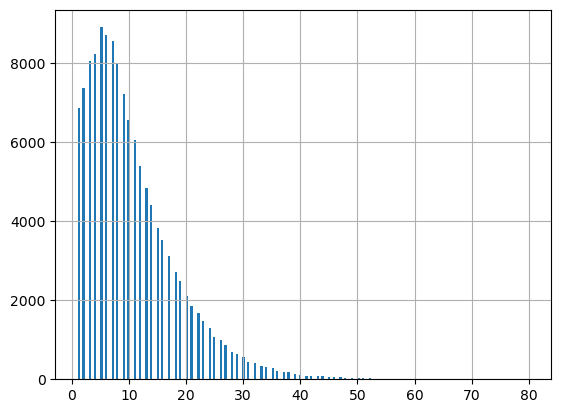

In [35]:
orders_and_users_dataset.groupby(['order_id']).good_foreign_id.agg(list).apply(lambda x: len(x)).hist(bins = 200)
#left-sided distribution - most of the baskets represented in the datasets contain less then 10-15 items in them

In [36]:
orders_and_users_dataset.groupby(['customer_id']).order_id.agg(list).apply(lambda x: len(x)).mean()
#avg. amount of orders per user

10.552759338155157

In [37]:
def return_indexes_to_drop(df): 
    baskets_dataset = df.groupby(['order_id']).agg(list)
    baskets_dataset['baskets_size'] = baskets_dataset.good_foreign_id.apply(lambda x: len(x))
    
    drop_indexes = baskets_dataset[baskets_dataset.baskets_size == 1].index.to_list()
    
    return drop_indexes

In [38]:
single_items_baskets = return_indexes_to_drop(orders_and_users_dataset)

In [39]:
instacart = orders_and_users_dataset[~orders_and_users_dataset.index.isin(single_items_baskets)]
instacart.shape

(1381791, 3)

In [43]:
#as there is no time data - we re splitting the datasets quaterly - 3/4 - train, 1/4 - test 
train_data = instacart[:1038462]
test_data =  instacart[~instacart.index.isin(train_data.index)]

In [46]:
def mask_values(lst, num):
    curr_lst = lst.copy()  
    new_list = sample(curr_lst, len(curr_lst) - num)
    return new_list

In [47]:
def create_masked_sample(df): 
    
    grouped_items = pd.DataFrame(df.groupby(['order_id']).agg(list)).reset_index()
    grouped_items['lists_len'] = grouped_items.good_foreign_id.apply(lambda x: len(x))
    grouped_items['num_to_mask'] = grouped_items['lists_len'].apply(lambda x: math.ceil(x * 0.2))
    grouped_items['lists_to_pred'] = grouped_items.apply(lambda row: mask_values(row['good_foreign_id'], 
                                                                                 row['num_to_mask']), axis=1)
    grouped_items = grouped_items[['order_id', 'customer_id', 'good_foreign_id', 'lists_len', 'num_to_mask',
           'lists_to_pred']].explode('lists_to_pred')

    masked_data = grouped_items[['order_id','lists_to_pred', 'customer_id']
                               ].rename({'lists_to_pred': 'good_foreign_id'}, axis = 1)
    
    return masked_data, grouped_items

In [48]:
masked_data, test_data_with_masked_stats = create_masked_sample(test_data)
#we gonna use masked_data for test and them joined stats from test_data_with_masked_stats for validation

In [49]:
test_data_with_masked_stats.customer_id = test_data_with_masked_stats.customer_id.apply(lambda x: x[0])

In [53]:
pred_dataset_instacart = ease.recommend_items(train_data, masked_data, 'order_id', 'good_foreign_id', top_n = 20)

Creating index mappings...
Index mappings created.
Creating sparse matrix...
Sparse matrix created.
Fitting EASE...
EASE fitted.
Generating user vectors...
User vectors generated.
Generating recommendations...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32547/32547 [00:51<00:00, 638.17it/s]


Recommendations generated.


In [54]:
pred_dataset_instacart.head(3)

,order_id,basket,vector,recs,preds
0,170,"[13176, 11182, 37766, 39190, 21137, 43772, 623...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[14, 10, 211, 277, 49, 26, 551, 28, 1434, 296...","[24852, 47209, 39275, 8518, 21137, 47766, 2752..."
1,349,"[25715, 30830, 11361, 36968, 5115, 33000, 4563...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[607, 138, 1170, 185, 2897, 94, 8626, 5902, 5...","[21903, 24184, 46667, 45007, 23029, 13176, 379..."
2,456,"[48118, 35365, 47626, 34229, 31506, 34591, 4972]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[268, 436, 145, 24, 49, 11314, 8964, 1303, 94...","[47626, 24838, 16797, 26604, 21137, 32520, 276..."


In [55]:
evaluation_df = test_data_with_masked_stats[['order_id','good_foreign_id', 'num_to_mask']
                             ].merge(pred_dataset_instacart).rename({'good_foreign_id': 'original_basket', 
                                                                    'basket': 'masked_basket'}, axis = 1)

In [56]:
evaluation_df.head(3)

,order_id,original_basket,num_to_mask,masked_basket,vector,recs,preds
0,170,"[18394, 37766, 13176, 6236, 5077, 8153, 43772,...",4,"[13176, 11182, 37766, 39190, 21137, 43772, 623...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[14, 10, 211, 277, 49, 26, 551, 28, 1434, 296...","[24852, 47209, 39275, 8518, 21137, 47766, 2752..."
1,170,"[18394, 37766, 13176, 6236, 5077, 8153, 43772,...",4,"[13176, 11182, 37766, 39190, 21137, 43772, 623...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[14, 10, 211, 277, 49, 26, 551, 28, 1434, 296...","[24852, 47209, 39275, 8518, 21137, 47766, 2752..."
2,170,"[18394, 37766, 13176, 6236, 5077, 8153, 43772,...",4,"[13176, 11182, 37766, 39190, 21137, 43772, 623...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[14, 10, 211, 277, 49, 26, 551, 28, 1434, 296...","[24852, 47209, 39275, 8518, 21137, 47766, 2752..."


In [57]:
classic_prec_rec_metrics = evaluation_df.copy()

classic_prec_rec_for_top_n_metrics = evaluation_df.copy()

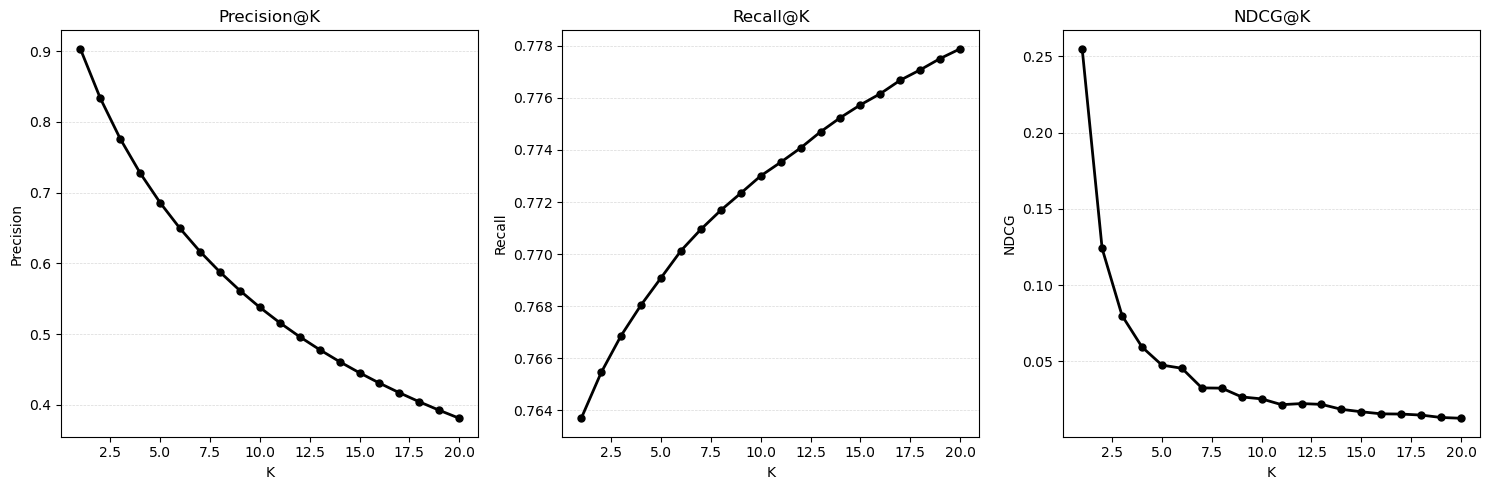

In [58]:
main_metrics.calculate_and_save_precision_recall(classic_prec_rec_metrics)
main_metrics.calculate_and_save_ndcg(classic_prec_rec_metrics)
pretty_plotter.plot_pretty_metrics(classic_prec_rec_metrics)

In [66]:
classic_prec_rec_metrics.describe().loc[:, classic_prec_rec_metrics.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,262747.000000,262747.000000,262747.000000
mean,0.537979,0.773004,0.025361
std,0.165909,0.079896,0.127239
min,0.000000,0.000000,0.000000
25%,0.444444,0.750000,0.000000
50%,0.550000,0.782609,0.000000
75%,0.666667,0.800000,0.000000
max,0.909091,1.000000,1.516991


In [70]:
top_n_list = train_data.good_foreign_id.value_counts()[:20].index.tolist()

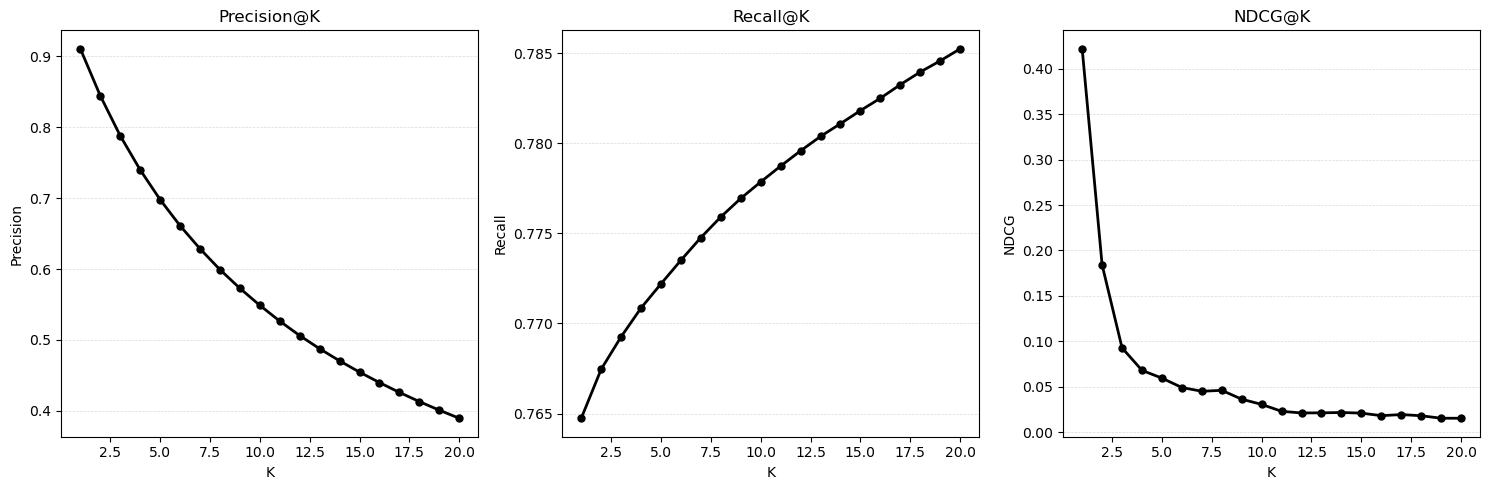

In [71]:
#here, instead of predictions from EASE we are usinf top 20 popular items as predictions to score metrics
main_metrics.calculate_precision_recall_top_n_items(classic_prec_rec_for_top_n_metrics, top_n_list)
main_metrics.calculate_and_save_ndcg_top_n_items(classic_prec_rec_for_top_n_metrics, top_n_list)
pretty_plotter.plot_pretty_metrics(classic_prec_rec_for_top_n_metrics)

In [72]:
classic_prec_rec_for_top_n_metrics.describe().loc[:, classic_prec_rec_for_top_n_metrics.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,262747.000000,262747.000000,262747.000000
mean,0.548826,0.777855,0.030455
std,0.167328,0.080780,0.130108
min,0.000000,0.000000,0.000000
25%,0.444444,0.750000,0.000000
50%,0.571429,0.785714,0.000000
75%,0.666667,0.800000,0.000000
max,0.924528,1.000000,1.445324


### 2. Ta Feng Dataset

In [73]:
ta_feng_dataset = pd.read_csv('../data/ta_feng/ta_feng_all_months_merged.csv')[
    ['TRANSACTION_DT', 'CUSTOMER_ID', 'PRODUCT_ID']]

In [74]:
ta_feng_dataset.TRANSACTION_DT = ta_feng_dataset.TRANSACTION_DT .apply(lambda x: x.replace('/', '-'))

ta_feng_dataset.TRANSACTION_DT = [datetime.strptime(date, '%m-%d-%Y').strftime('%Y-%m-%d') for date in ta_feng_dataset.TRANSACTION_DT]

In [75]:
df = ta_feng_dataset.rename({'TRANSACTION_DT': 'date', 'CUSTOMER_ID': 'customer_id', 
                               'PRODUCT_ID': 'good_foreign_id'}, axis = 1)

In [76]:
df.shape

(817741, 3)

In [77]:
def return_indexes_to_drop(df): 
    baskets_dataset = df.groupby(['customer_id']).agg(list)
    baskets_dataset['baskets_size'] = baskets_dataset.good_foreign_id.apply(lambda x: len(x))
    
    drop_indexes = baskets_dataset[baskets_dataset.baskets_size == 1].index.to_list()
    
    return drop_indexes

In [78]:
single_items_baskets = return_indexes_to_drop(df)

te_feng = df[~df.index.isin(single_items_baskets)]
te_feng.shape

(817501, 3)

In [80]:
te_feng.head()

,date,customer_id,good_foreign_id
0,2000-11-01,1104905,4710199010372
1,2000-11-01,418683,4710857472535
2,2000-11-01,1057331,4710043654103
3,2000-11-01,1849332,4710126092129
4,2000-11-01,1981995,4710176021445


In [81]:
def labelling_order_id(df):
    
    #setting order id as its not impicitly mentioned in original data 
    #we count order id as label of basket of items for users puchases within a certain day

    grouped = df.groupby(['date', 'customer_id'])
    df['order_id'] = grouped.ngroup() + 1
    
    return df

labelling_order_id(te_feng).head(3)

,date,customer_id,good_foreign_id,order_id
0,2000-11-01,1104905,4710199010372,78
1,2000-11-01,418683,4710857472535,34
2,2000-11-01,1057331,4710043654103,75


<Axes: >

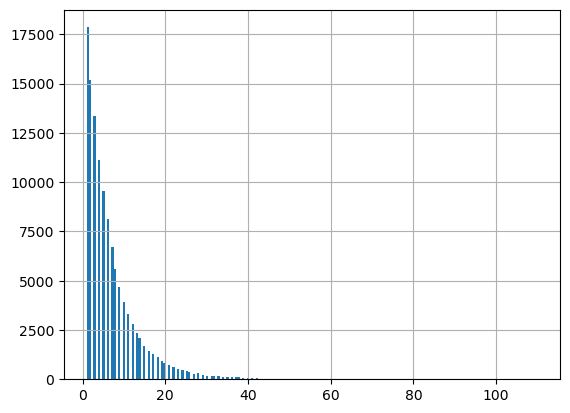

In [82]:
te_feng.groupby(['order_id']).good_foreign_id.agg(list).apply(lambda x: len(x)).hist(bins = 200)
#left-sided distribution - most of the baskets represented in the datasets contain less then 10 items

In [83]:
te_feng.groupby(['customer_id']).order_id.agg(list).apply(lambda x: len(x)).mean()
#avg. amount of orders per user

25.336298270625427

In [84]:
def split_train_test(group, time_threshold):
    
    train = group[group['date'] <= time_threshold]
    test = group[group['date'] > time_threshold]
    
    
    return train,test

In [85]:
time_threshold = '2000-11-06'

train_data, test_data = zip(*te_feng.groupby('order_id').apply(split_train_test, 
                                                                 time_threshold=time_threshold))

train_data = pd.concat(train_data)
test_data = pd.concat(test_data)

In [86]:
masked_data, test_data_with_masked_stats = create_masked_sample(test_data)

In [87]:
pred_dataset_te_feng = ease.recommend_items(train_data, masked_data, 'order_id', 'good_foreign_id', top_n = 20)

Creating index mappings...
Index mappings created.
Creating sparse matrix...
Sparse matrix created.
Fitting EASE...
EASE fitted.
Generating user vectors...
User vectors generated.
Generating recommendations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113418/113418 [02:31<00:00, 748.36it/s]


Recommendations generated.


In [88]:
evaluation_df = test_data_with_masked_stats[['order_id','good_foreign_id', 'num_to_mask']
                             ].merge(pred_dataset_te_feng).rename({'good_foreign_id': 'original_basket', 
                                                                    'basket': 'masked_basket'}, axis = 1)

In [89]:
classic_prec_rec_metrics = evaluation_df.copy()

classic_prec_rec_for_top_n_metrics = evaluation_df.copy()

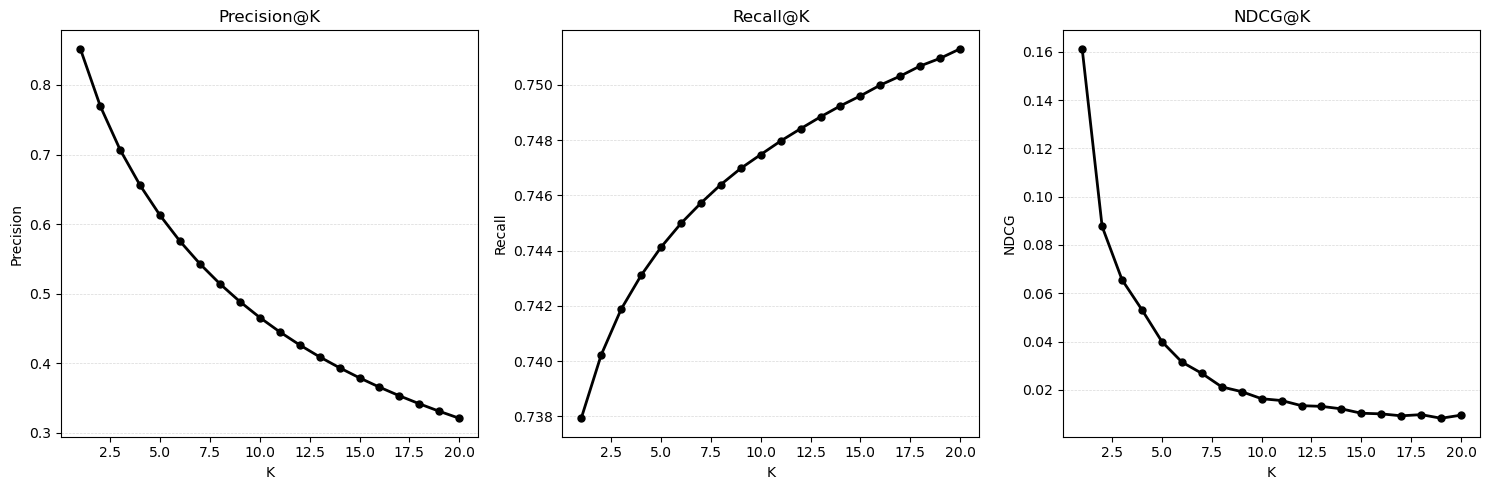

In [90]:
main_metrics.calculate_and_save_precision_recall(classic_prec_rec_metrics)
main_metrics.calculate_and_save_ndcg(classic_prec_rec_metrics)
pretty_plotter.plot_pretty_metrics(classic_prec_rec_metrics)

In [91]:
classic_prec_rec_metrics.describe().loc[:, classic_prec_rec_metrics.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,580109.000000,580109.000000,580109.000000
mean,0.465571,0.747475,0.016288
std,0.199446,0.143099,0.107322
min,0.000000,0.000000,0.000000
25%,0.307692,0.750000,0.000000
50%,0.473684,0.777778,0.000000
75%,0.615385,0.800000,0.000000
max,1.000000,1.000000,1.678702


In [95]:
top_n_list = train_data.good_foreign_id.value_counts()[:20].index.tolist()

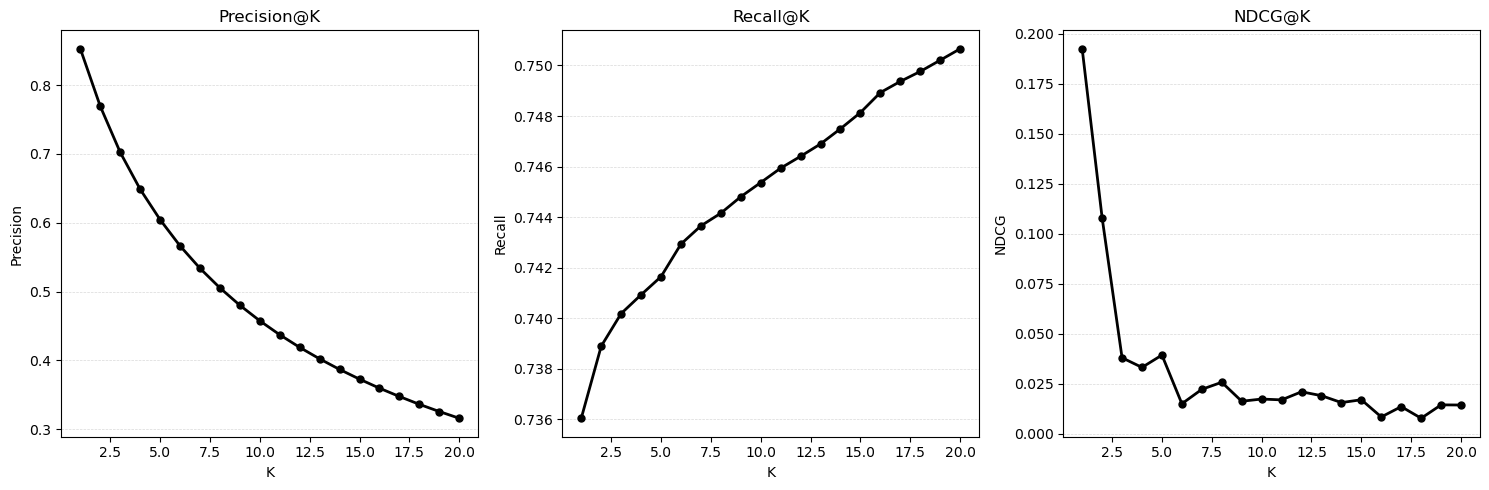

In [96]:
main_metrics.calculate_precision_recall_top_n_items(classic_prec_rec_for_top_n_metrics, top_n_list)
main_metrics.calculate_and_save_ndcg_top_n_items(classic_prec_rec_for_top_n_metrics, top_n_list)
pretty_plotter.plot_pretty_metrics(classic_prec_rec_for_top_n_metrics)

In [98]:
classic_prec_rec_for_top_n_metrics.describe().loc[:, classic_prec_rec_for_top_n_metrics.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,580109.000000,580109.000000,580109.000000
mean,0.457568,0.745370,0.017285
std,0.191333,0.134668,0.120186
min,0.000000,0.000000,0.000000
25%,0.307692,0.750000,0.000000
50%,0.470588,0.777778,0.000000
75%,0.600000,0.800000,0.000000
max,0.946809,1.000000,1.614416


### 3. DunnHumby Retail Transaction Data

In [99]:
dh_dataset = pd.read_csv('../data/dunnhumby/transaction_data.csv')[['household_key', 'BASKET_ID', 'PRODUCT_ID']].rename({'household_key': 'customer_id',
                                                                                                               'BASKET_ID': 'order_id',
                                                                                                               'PRODUCT_ID': 'good_foreign_id'}
                                                                                                             , axis = 1)

In [100]:
print(dh_dataset.shape)
dh_dataset.head()

(2595732, 3)


,customer_id,order_id,good_foreign_id
0,2375,26984851472,1004906
1,2375,26984851472,1033142
2,2375,26984851472,1036325
3,2375,26984851472,1082185
4,2375,26984851472,8160430


<Axes: >

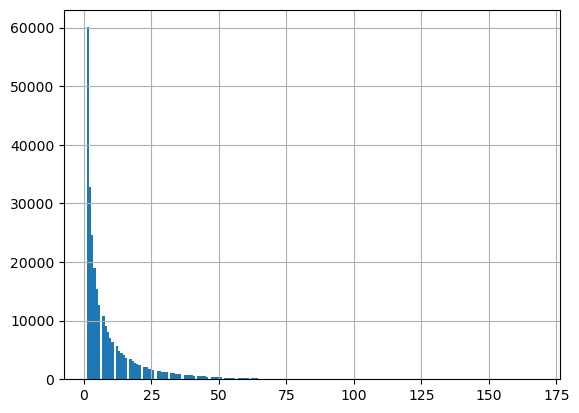

In [101]:
dh_dataset.groupby(['order_id']).good_foreign_id.agg(list).apply(lambda x: len(x)).hist(bins = 200)
#left-sided distribution - most of the baskets represented in the datasets contain less then 10-15 items in them

In [102]:
single_items_baskets = return_indexes_to_drop(dh_dataset)

In [103]:
retail = dh_dataset[~dh_dataset.index.isin(single_items_baskets)]
retail.shape

(2595732, 3)

In [104]:
#as there is no time data - we re splitting the datasets quaterly - 3/4 - train, 1/4 - test 
train_data = retail[:1946799]
test_data =  retail[~retail.index.isin(train_data.index)]

In [105]:
train_data.shape, test_data.shape

((1946799, 3), (648933, 3))

In [106]:
masked_data, test_data_with_masked_stats = create_masked_sample(test_data)
#we gonna use masked_data for test and them joined stats from test_data_with_masked_stats for validation

In [109]:
pred_dataset_retail = ease.recommend_items(train_data, masked_data, 'order_id', 'good_foreign_id', top_n = 20)

Creating index mappings...
Index mappings created.
Creating sparse matrix...
Sparse matrix created.
Fitting EASE...
EASE fitted.
Generating user vectors...
User vectors generated.
Generating recommendations...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66351/66351 [02:45<00:00, 399.72it/s]


Recommendations generated.


In [110]:
evaluation_df = test_data_with_masked_stats[['order_id','good_foreign_id', 'num_to_mask']
                             ].merge(pred_dataset_retail).rename({'good_foreign_id': 'original_basket', 
                                                                    'basket': 'masked_basket'}, axis = 1)

In [113]:
classic_prec_rec_metrics = evaluation_df.copy()

classic_prec_rec_for_top_n_metrics = evaluation_df.copy()

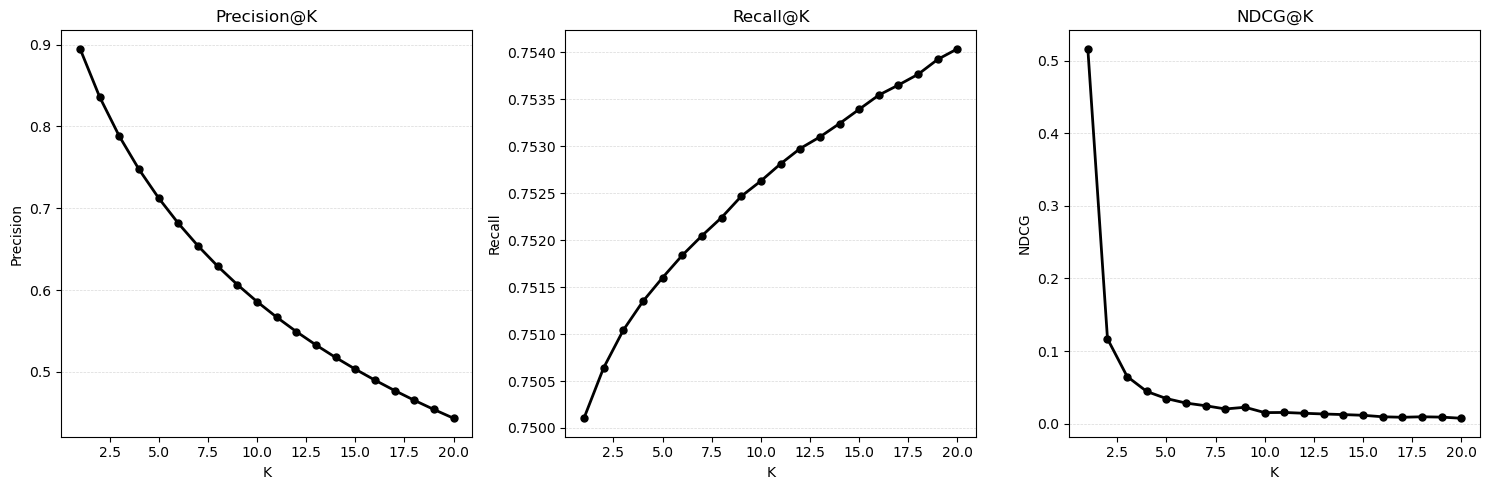

In [114]:
main_metrics.calculate_and_save_precision_recall(classic_prec_rec_metrics)
main_metrics.calculate_and_save_ndcg(classic_prec_rec_metrics)
pretty_plotter.plot_pretty_metrics(classic_prec_rec_metrics)

In [115]:
classic_prec_rec_metrics.describe().loc[:, classic_prec_rec_metrics.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,500436.000000,500436.000000,500436.000000
mean,0.586019,0.752631,0.015144
std,0.221750,0.135804,0.117529
min,0.000000,0.000000,0.000000
25%,0.444444,0.761905,0.000000
50%,0.629630,0.785714,0.000000
75%,0.763158,0.800000,0.000000
max,0.950820,1.000000,1.765760


In [116]:
top_n_list = train_data.good_foreign_id.value_counts()[:20].index.tolist()

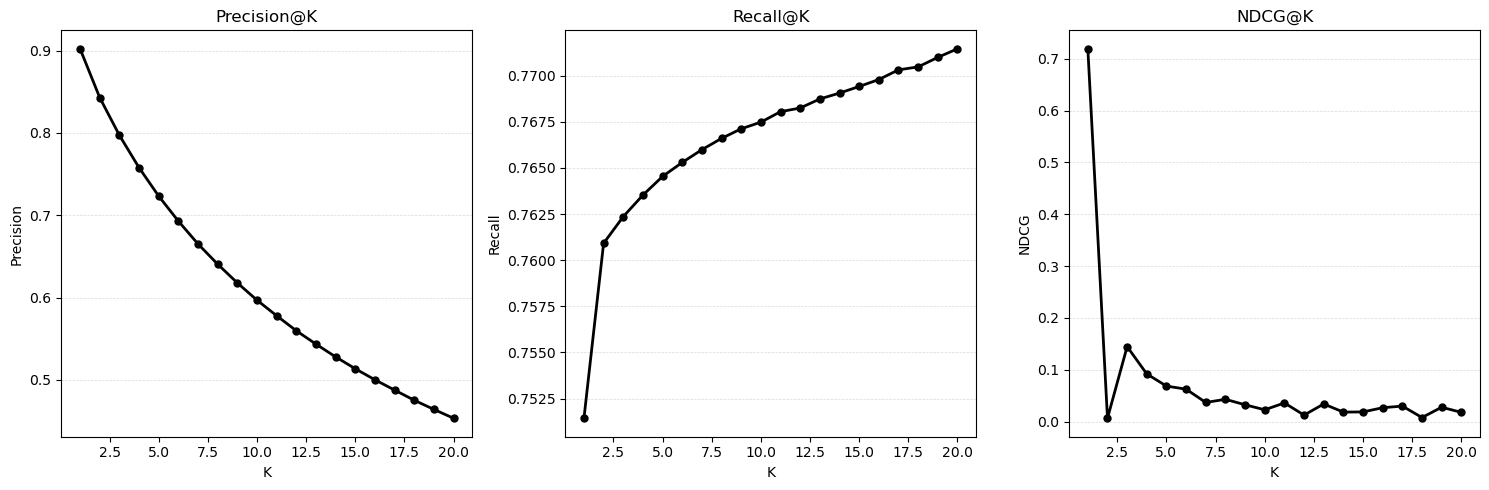

In [117]:
main_metrics.calculate_precision_recall_top_n_items(classic_prec_rec_for_top_n_metrics, top_n_list)
main_metrics.calculate_and_save_ndcg_top_n_items(classic_prec_rec_for_top_n_metrics, top_n_list)
pretty_plotter.plot_pretty_metrics(classic_prec_rec_for_top_n_metrics)

In [118]:
classic_prec_rec_for_top_n_metrics.describe().loc[:, classic_prec_rec_for_top_n_metrics.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,500436.000000,500436.000000,500436.000000
mean,0.596939,0.767481,0.022675
std,0.221038,0.117301,0.122586
min,0.000000,0.000000,0.000000
25%,0.444444,0.769231,0.000000
50%,0.652174,0.789474,0.000000
75%,0.777778,0.800000,0.000000
max,0.950413,1.000000,1.663536
